Iteración 1: cambio total en centroides = 3.126486
Iteración 2: cambio total en centroides = 0.126727
Iteración 3: cambio total en centroides = 0.034593
Iteración 4: cambio total en centroides = 0.049868
Iteración 5: cambio total en centroides = 0.047679
Iteración 6: cambio total en centroides = 0.131963
Iteración 7: cambio total en centroides = 0.454084
Iteración 8: cambio total en centroides = 1.521518
Iteración 9: cambio total en centroides = 2.411524
Iteración 10: cambio total en centroides = 0.062197
Iteración 11: cambio total en centroides = 0.000000
Convergencia alcanzada.

Dataset 1: K-means convergió en 11 iteraciones.
Centroides finales:
 [[ 4.03530049  3.98879264]
 [-0.04442848  4.98993008]
 [-0.0073731  -0.02307762]]


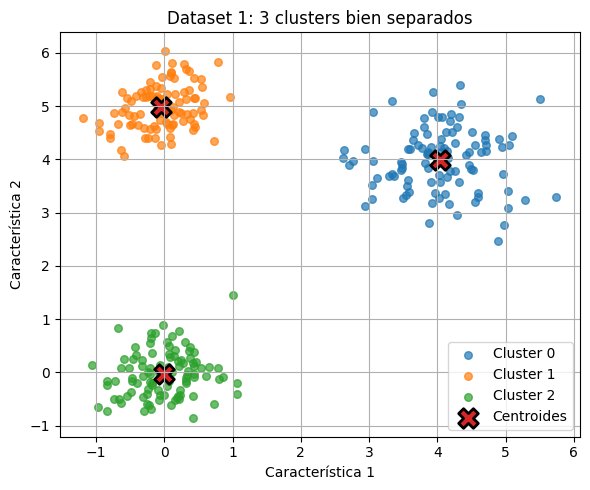

Iteración 1: cambio total en centroides = 2.166204
Iteración 2: cambio total en centroides = 0.694345
Iteración 3: cambio total en centroides = 0.636919
Iteración 4: cambio total en centroides = 1.292358
Iteración 5: cambio total en centroides = 2.598570
Iteración 6: cambio total en centroides = 1.539742
Iteración 7: cambio total en centroides = 0.114428
Iteración 8: cambio total en centroides = 0.000000
Convergencia alcanzada.

Dataset 2: K-means convergió en 8 iteraciones.
Centroides finales:
 [[-3.0046696   2.92206445]
 [ 3.03967033 -3.06293179]
 [ 3.1557194   2.98730763]
 [-2.95490462 -3.00011706]]


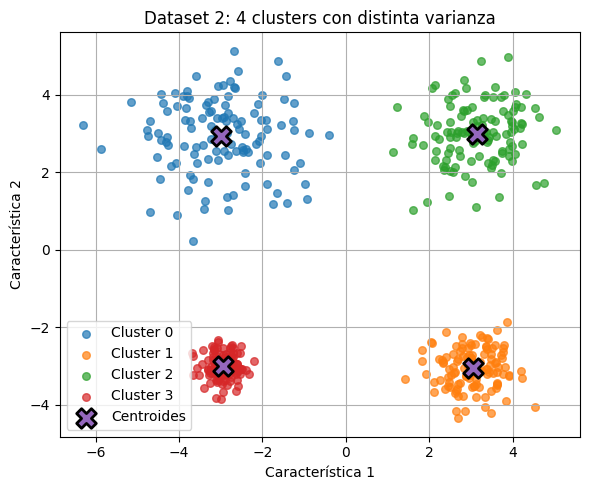

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 1. Generación de datasets
# ==========================

def make_synthetic_clusters(centers, n_points_per_cluster=100, std=0.5, random_state=None):
    """
    Genera un dataset 2D tipo "blobs" a partir de centros dados.
    
    Parameters
    ----------
    centers : list of tuple
        Lista de centros, por ejemplo [(0,0), (3,3), (-3,2)].
    n_points_per_cluster : int
        Número de puntos por cada cluster.
    std : float or list
        Desviación estándar de la nube de puntos alrededor de cada centro.
        Puede ser:
        - float: misma std para todos
        - list del mismo tamaño que centers: std diferente por centro
    random_state : int or None
        Semilla para reproducibilidad.
    
    Returns
    -------
    X : np.ndarray, shape (n_points, 2)
        Puntos generados.
    y_true : np.ndarray, shape (n_points,)
        Etiquetas verdaderas de cluster (0,1,2,...).
    """
    rng = np.random.default_rng(random_state)
    
    centers = np.array(centers)
    k = len(centers)
    
    if isinstance(std, (int, float)):
        std = [std] * k
    std = np.asarray(std)
    
    all_points = []
    all_labels = []
    for idx, (cx, cy) in enumerate(centers):
        # Generamos puntos alrededor del centro (cx, cy)
        points = rng.normal(loc=[cx, cy], scale=std[idx], size=(n_points_per_cluster, 2))
        all_points.append(points)
        all_labels.append(np.full(n_points_per_cluster, idx, dtype=int))
    
    X = np.vstack(all_points)
    y_true = np.concatenate(all_labels)
    return X, y_true


# ==========================
# 2. Implementación de K-means
# ==========================

def initialize_centroids(X, k, random_state=None):
    """
    Inicializa los centroides eligiendo k puntos aleatorios del dataset.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Datos.
    k : int
        Número de clusters.
    random_state : int or None
        Semilla para reproducibilidad.
    
    Returns
    -------
    centroids : np.ndarray, shape (k, n_features)
    """
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    
    # Elegimos k índices distintos aleatorios
    indices = rng.choice(n_samples, size=k, replace=False)
    centroids = X[indices]
    return centroids


def compute_distances(X, centroids):
    """
    Calcula la distancia Euclidiana de cada punto a cada centroide.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    centroids : np.ndarray, shape (k, n_features)
    
    Returns
    -------
    distances : np.ndarray, shape (n_samples, k)
        distances[i, j] = distancia del punto i al centroide j
    """
    # Usamos broadcasting:
    # X: (n_samples, n_features)
    # centroids: (k, n_features)
    # X[:, None, :] -> (n_samples, 1, n_features)
    # centroids[None, :, :] -> (1, k, n_features)
    # Resultado de la resta: (n_samples, k, n_features)
    diff = X[:, None, :] - centroids[None, :, :]
    
    # Distancia Euclidiana: sqrt(sum(diff^2))
    distances = np.linalg.norm(diff, axis=2)  # (n_samples, k)
    return distances


def assign_clusters(X, centroids):
    """
    Asigna cada punto al centroide más cercano.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    centroids : np.ndarray, shape (k, n_features)
    
    Returns
    -------
    labels : np.ndarray, shape (n_samples,)
        Índice del centroide asignado para cada punto.
    """
    distances = compute_distances(X, centroids)
    # Tomamos el índice del centroide con menor distancia
    labels = np.argmin(distances, axis=1)
    return labels


def update_centroids(X, labels, k):
    """
    Recalcula los centroides como el promedio de los puntos asignados a cada cluster.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    labels : np.ndarray, shape (n_samples,)
        Etiquetas de cluster para cada punto.
    k : int
        Número de clusters.
    
    Returns
    -------
    new_centroids : np.ndarray, shape (k, n_features)
    """
    n_features = X.shape[1]
    new_centroids = np.zeros((k, n_features))
    
    for cluster_idx in range(k):
        # Seleccionamos los puntos que pertenecen al cluster cluster_idx
        points_in_cluster = X[labels == cluster_idx]
        
        if len(points_in_cluster) == 0:
            # Caso raro: ningún punto asignado a este cluster.
            # Podemos dejar el centroide como está, o re-inicializar.
            # Aquí, para evitar NaNs, lo dejamos como 0 o podríamos manejarlo distinto.
            # En una implementación más robusta, lo re-inicializaríamos aleatoriamente.
            continue
        else:
            new_centroids[cluster_idx] = points_in_cluster.mean(axis=0)
    
    return new_centroids


def kmeans(X, k, max_iter=100, tol=1e-4, random_state=None, verbose=False):
    """
    Implementación básica de K-means.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    k : int
        Número de clusters.
    max_iter : int
        Máximo número de iteraciones.
    tol : float
        Tolerancia para el cambio entre centroides (criterio de parada).
    random_state : int or None
        Semilla para reproducibilidad.
    verbose : bool
        Si True, imprime información en cada iteración.
    
    Returns
    -------
    centroids : np.ndarray, shape (k, n_features)
        Centroides finales.
    labels : np.ndarray, shape (n_samples,)
        Asignación final de clusters.
    n_iter : int
        Número de iteraciones realizadas.
    """
    # 1. Inicializar centroides
    centroids = initialize_centroids(X, k, random_state=random_state)
    
    for it in range(max_iter):
        # 2. Asignar cada punto al centroide más cercano
        labels = assign_clusters(X, centroids)
        
        # 3. Calcular nuevos centroides
        new_centroids = update_centroids(X, labels, k)
        
        # 4. Comprobar convergencia (si los centroides casi no cambian)
        shift = np.linalg.norm(new_centroids - centroids)
        
        if verbose:
            print(f"Iteración {it+1}: cambio total en centroides = {shift:.6f}")
        
        if shift < tol:
            if verbose:
                print("Convergencia alcanzada.")
            centroids = new_centroids
            break
        
        centroids = new_centroids
    
    return centroids, labels, it + 1


# ==========================
# 3. Ejemplos aplicados
# ==========================

def plot_clusters(X, labels, centroids, title="Clusters encontrados"):
    """
    Gráfica 2D de los puntos y los centroides.
    Solo aplica si X tiene 2 características (columna 0 y 1).
    """
    plt.figure(figsize=(6, 5))
    
    k = centroids.shape[0]
    
    for cluster_idx in range(k):
        points = X[labels == cluster_idx]
        plt.scatter(points[:, 0], points[:, 1], s=30, alpha=0.7, label=f"Cluster {cluster_idx}")
    
    # Dibujar centroides
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        s=200,
        marker="X",
        edgecolor="black",
        linewidth=2,
        label="Centroides"
    )
    
    plt.title(title)
    plt.xlabel("Característica 1")
    plt.ylabel("Característica 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # =====================
    # Dataset 1: 3 clusters claros
    # =====================
    centers1 = [(0, 0), (4, 4), (0, 5)]
    X1, y_true1 = make_synthetic_clusters(
        centers=centers1,
        n_points_per_cluster=100,
        std=[0.5, 0.6, 0.4],
        random_state=42
    )
    
    k = 3
    centroids1, labels1, n_iter1 = kmeans(X1, k=k, max_iter=100, tol=1e-4, random_state=0, verbose=True)
    print(f"\nDataset 1: K-means convergió en {n_iter1} iteraciones.")
    print("Centroides finales:\n", centroids1)
    
    plot_clusters(X1, labels1, centroids1, title="Dataset 1: 3 clusters bien separados")
    
    # =====================
    # Dataset 2: 4 clusters con distintas dispersiones
    # =====================
    centers2 = [(-3, -3), (-3, 3), (3, -3), (3, 3)]
    X2, y_true2 = make_synthetic_clusters(
        centers=centers2,
        n_points_per_cluster=120,
        std=[0.3, 1.0, 0.5, 0.8],
        random_state=123
    )
    
    k2 = 4
    centroids2, labels2, n_iter2 = kmeans(X2, k=k2, max_iter=100, tol=1e-4, random_state=1, verbose=True)
    print(f"\nDataset 2: K-means convergió en {n_iter2} iteraciones.")
    print("Centroides finales:\n", centroids2)
    
    plot_clusters(X2, labels2, centroids2, title="Dataset 2: 4 clusters con distinta varianza")


Iteración 1:
  Centroide 1: [1.66666667 2.33333333]
  Centroide 2: [5. 3.]
Iteración 2:
  Centroide 1: [1.66666667 2.33333333]
  Centroide 2: [5. 3.]
Convergencia alcanzada (ningún cluster cambió).


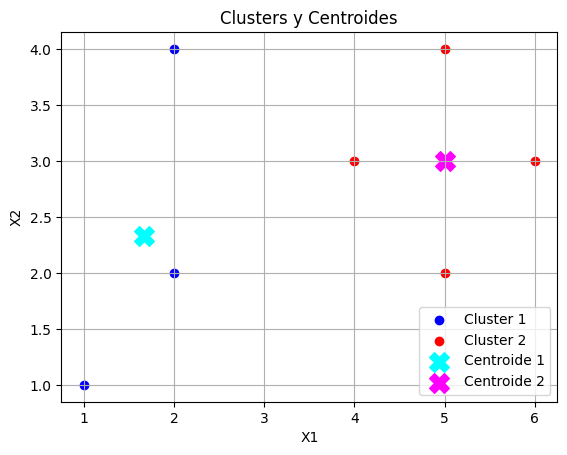

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Distancia entre un punto y un centroide
def distancia(punto, centroide):
    return np.sqrt((punto[0] - centroide[0])**2 + (punto[1] - centroide[1])**2)

# Asignación de clusters
def asignar_clusters(data, c1, c2):
    cluster1 = []
    cluster2 = []
    for punto in data:
        d1 = distancia(punto, c1)
        d2 = distancia(punto, c2)
        if d1 < d2:
            cluster1.append(punto)
        else:
            cluster2.append(punto)
    return np.array(cluster1), np.array(cluster2)

# Actualización de centroides (solo si hay cambios)
def actualizar_centroides(cluster1, cluster2, c1, c2, cluster1_prev, cluster2_prev):
    # Centroide 1
    if cluster1_prev is not None and np.array_equal(cluster1, cluster1_prev):
        # No cambia el cluster entonces mantenemos el centroide
        c1_new = c1.copy()
    else:
        # Cambió entonces recalculamos
        c1_new = np.mean(cluster1, axis=0)

    # Centroide 2
    if cluster2_prev is not None and np.array_equal(cluster2, cluster2_prev):
        c2_new = c2.copy()
    else:
        c2_new = np.mean(cluster2, axis=0)

    return c1_new, c2_new

# k-means completo 
def kmeans(data, c1, c2, max_iters=10):
    cluster1_prev = None
    cluster2_prev = None

    for i in range(max_iters):
        # 1) Asignar clusters
        cluster1, cluster2 = asignar_clusters(data, c1, c2)

        # 2) Actualizar solo si cambiaron los clusters
        c1_new, c2_new = actualizar_centroides(cluster1, cluster2, c1, c2, cluster1_prev, cluster2_prev)

        print(f"Iteración {i+1}:")
        print(f"  Centroide 1: {c1_new}")
        print(f"  Centroide 2: {c2_new}")

        # 3) Comprobar convergencia:
        #    si ambos clusters son iguales a los previos se detiene
        if (cluster1_prev is not None and 
            cluster2_prev is not None and 
            np.array_equal(cluster1, cluster1_prev) and 
            np.array_equal(cluster2, cluster2_prev)):
            print("Convergencia alcanzada.")
            break

        # 4) Actualizar variables para la siguiente iteración
        c1, c2 = c1_new, c2_new
        cluster1_prev = cluster1.copy()
        cluster2_prev = cluster2.copy()

    return c1, c2, cluster1, cluster2

# Visualización
def plot_clusters(cluster1, cluster2, c1, c2):
    plt.scatter(cluster1[:,0], cluster1[:,1], color='blue', label='Cluster 1')
    plt.scatter(cluster2[:,0], cluster2[:,1], color='red', label='Cluster 2')
    plt.scatter(c1[0], c1[1], color='cyan', marker='X', s=200, label='Centroide 1')
    plt.scatter(c2[0], c2[1], color='magenta', marker='X', s=200, label='Centroide 2')
    plt.title('Clusters y Centroides')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid()
    plt.show()

# Mi implementación de K-means
data = np.array([[1,1],[2,2],[2,4],[4,3],[5,2],[5,4],[6,3]]) # Defino el dataset
# Establezco los centroides iniciales
c1 = [3,5]
c2 = [6,4]
c1_final, c2_final, cluster1, cluster2 = kmeans(data, c1, c2, max_iters=5)
plot_clusters(cluster1, cluster2, c1_final, c2_final) 



Centroides encontrados:
 [[-1.60811992  2.85881658]
 [ 1.95159369  0.83467497]
 [ 0.95625704  4.37226546]]
Inercia (SSE total): 212.35550348922902


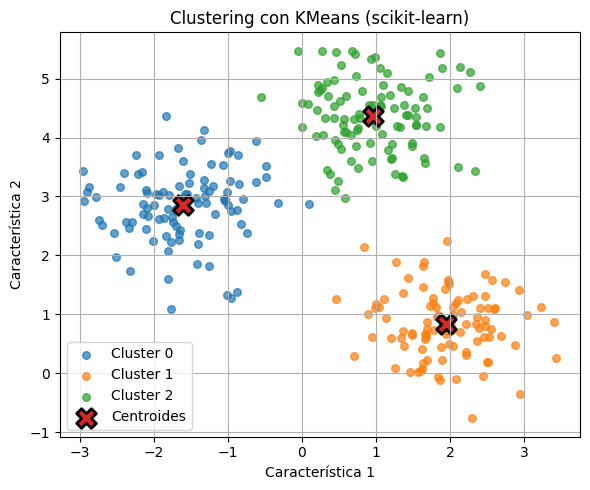

In [6]:
# Implementación usando scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# 1) Generar un dataset de ejemplo (similar a lo que hacíamos a mano)
#    3 clusters en 2D
X, y_true = make_blobs(
    n_samples=300,      # 300 puntos
    centers=3,          # 3 centros
    cluster_std=0.60,   # dispersión de cada cluster
    random_state=0
)

# 2) Crear el modelo KMeans
#    n_clusters = número de grupos que queremos encontrar
k = 3
kmeans = KMeans(
    n_clusters=k,
    n_init=10,          # cuántas veces se re-inicializa con centroides aleatorios
    max_iter=300,       # máx. iteraciones por inicialización
    random_state=0
)

# 3) Ajustar el modelo a los datos (aquí se ejecuta el algoritmo)
kmeans.fit(X)

# 4) Obtener información importante del modelo
labels = kmeans.labels_             # etiqueta (cluster) asignada a cada punto
centroids = kmeans.cluster_centers_ # coordenadas de los centroides
inercia = kmeans.inertia_           # suma de distancias cuadradas dentro de cada cluster

print("Centroides encontrados:\n", centroids)
print("Inercia (SSE total):", inercia)

# 5) Graficar los puntos y los centroides
plt.figure(figsize=(6, 5))

# Pintamos cada cluster con un color diferente según labels
for cluster_id in range(k):
    puntos_cluster = X[labels == cluster_id]
    plt.scatter(
        puntos_cluster[:, 0],
        puntos_cluster[:, 1],
        s=30,
        alpha=0.7,
        label=f"Cluster {cluster_id}"
    )

# Dibujamos los centroides
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=200,
    marker="X",
    edgecolor="black",
    linewidth=2,
    label="Centroides"
)

plt.title("Clustering con KMeans (scikit-learn)")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Centroides iniciales:
  Centroide 0 inicial: [5.6 2.7 4.2 1.3]
  Centroide 1 inicial: [6.8 2.8 4.8 1.4]
  Centroide 2 inicial: [7.2 3.2 6.  1.8]

 Iteración 1 
  Centroide 0: [5.29333333 3.10111111 2.67888889 0.74666667] | Puntos en cluster 0: 90
  Centroide 1: [6.41515152 2.89393939 4.91515152 1.66666667] | Puntos en cluster 1: 33
  Centroide 2: [6.97777778 3.11111111 5.94074074 2.13703704] | Puntos en cluster 2: 27

 Iteración 2 
  Centroide 0: [5.05666667 3.26833333 1.81       0.38833333] | Puntos en cluster 0: 60
  Centroide 1: [6.11230769 2.84615385 4.70153846 1.58461538] | Puntos en cluster 1: 65
  Centroide 2: [7.032 3.1   5.98  2.144] | Puntos en cluster 2: 25

 Iteración 3 
  Centroide 0: [5.00566038 3.36981132 1.56037736 0.29056604] | Puntos en cluster 0: 53
  Centroide 1: [6.         2.78153846 4.52153846 1.48153846] | Puntos en cluster 1: 65
  Centroide 2: [6.9125   3.1      5.846875 2.13125 ] | Puntos en cluster 2: 32

 Iteración 4 
  Centroide 0: [5.006 3.428 1.462 0.246

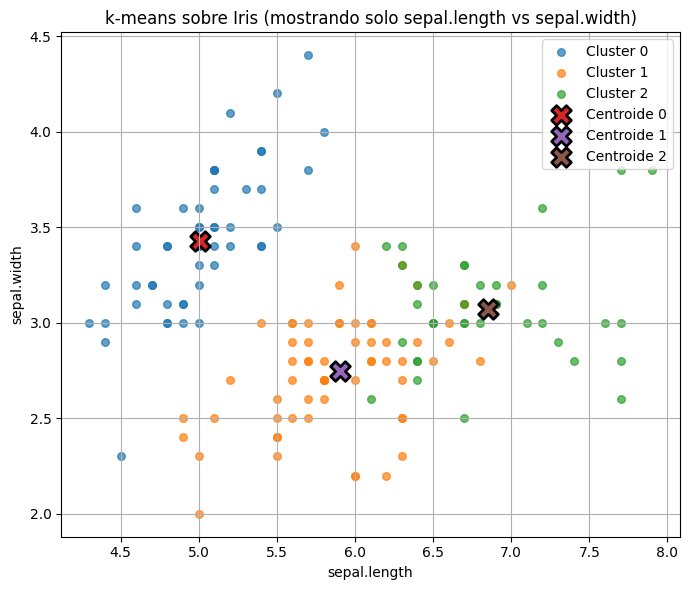

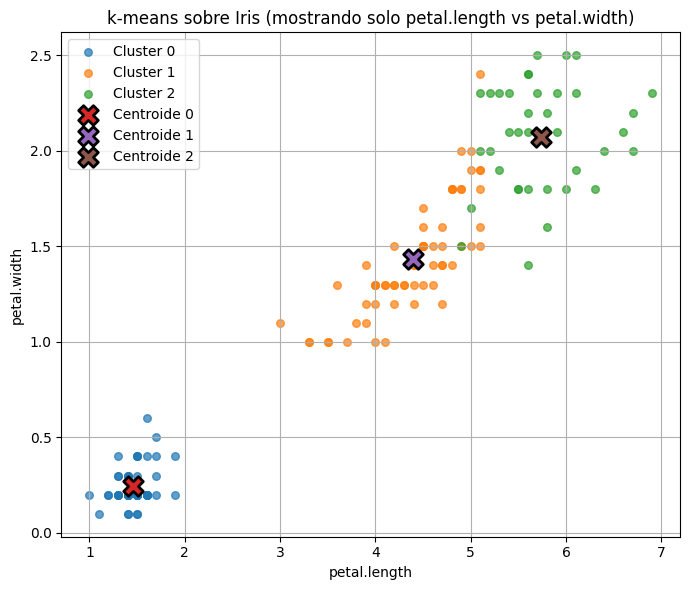

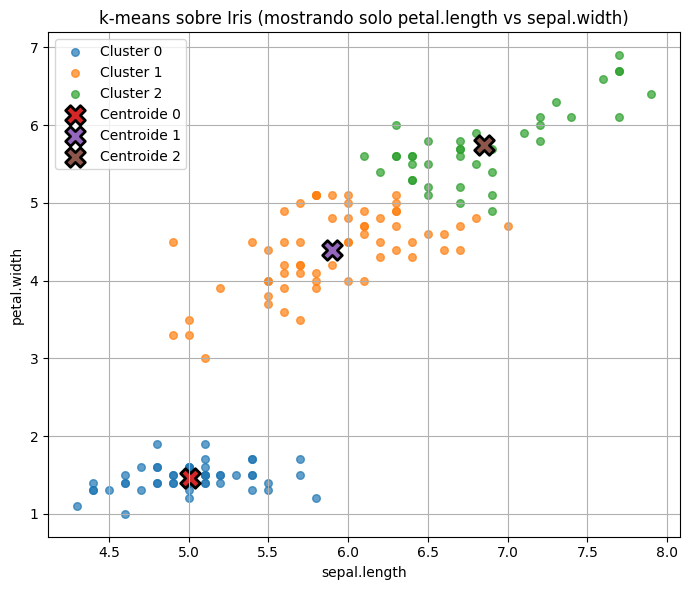

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Funciones base

# Distancia euclidiana en n dimensiones
def distancia(punto, centroide):
    suma = 0.0
    for i in range(len(punto)):
        suma += (punto[i] - centroide[i])**2
    return np.sqrt(suma)


# Asignación de puntos a k clusters, según el centroide más cercano
def asignar_clusters(data, centroides):
    k = len(centroides)
    clusters = [[] for _ in range(k)]  # lista de listas

    for punto in data:
        # calcular distancia a cada centroide
        distancias = [distancia(punto, c) for c in centroides]
        # índice del centroide más cercano
        idx_min = int(np.argmin(distancias))
        clusters[idx_min].append(punto)

    # convertir cada lista a np.array
    clusters = [np.array(cluster) for cluster in clusters]
    return clusters


# Actualización de centroides con control de cambios por cluster
def actualizar_centroides(clusters, centroides_prev, clusters_prev):
    k = len(clusters)
    nuevos_centroides = []

    for i in range(k):
        # Si tenemos clusters_prev y este cluster no cambió, mantenemos el centroide
        if clusters_prev is not None and np.array_equal(clusters[i], clusters_prev[i]):
            nuevos_centroides.append(centroides_prev[i].copy())
        else:
            # Si el cluster tiene puntos, recalculamos la media
            if len(clusters[i]) > 0:
                nuevos_centroides.append(np.mean(clusters[i], axis=0))
            else:
                # Cluster vacío: mantenemos el centroide anterior
                nuevos_centroides.append(centroides_prev[i].copy())

    return nuevos_centroides


# Implementación general de k-means para n dimensiones y k clusters
def kmeans(data, centroides_iniciales, max_iters=20):
    centroides = [c.copy() for c in centroides_iniciales]
    clusters_prev = None
    k = len(centroides)

    for it in range(max_iters):
        print(f"\n Iteración {it+1} ")

        # Asignar puntos a los clusters
        clusters = asignar_clusters(data, centroides)

        # Actualizar centroides
        nuevos_centroides = actualizar_centroides(clusters, centroides, clusters_prev)

        # Mostrar info de esta iteración
        for i, c in enumerate(nuevos_centroides):
            n_puntos = len(clusters[i])
            print(f"  Centroide {i}: {c} | Puntos en cluster {i}: {n_puntos}")

        # 3) Verificar convergencia
        if clusters_prev is not None:
            sin_cambios = True
            for i in range(k):
                if not np.array_equal(clusters[i], clusters_prev[i]):
                    sin_cambios = False
                    break
            if sin_cambios:
                print("Convergencia alcanzada: ningún cluster cambió.")
                centroides = nuevos_centroides
                break

        # 4) Preparar siguiente iteración
        centroides = nuevos_centroides
        clusters_prev = [c.copy() for c in clusters]

    return centroides, clusters


# Cargar Iris y ejecutar k-means

# Cargar el CSV de Iris
df = pd.read_csv("iris.csv")

# Elegimos las columnas (n dimensiones)
cols = ["sepal.length", "sepal.width", "petal.length", "petal.width"]
X = df[cols].values  # shape (150, 4) 

# Definir número de clusters 
k = 3

# Inicializar centroides con k puntos aleatorios de los datos
rng = np.random.default_rng(0)
indices_iniciales = rng.choice(len(X), size=k, replace=False)
centroides_iniciales = [X[i] for i in indices_iniciales]

print("\nCentroides iniciales:")
for i, c in enumerate(centroides_iniciales):
    print(f"  Centroide {i} inicial: {c}")

# Ejecutar k-means
centroides_finales, clusters_finales = kmeans(X, centroides_iniciales, max_iters=50)

print("\nCentroides finales:")
for i, c in enumerate(centroides_finales):
    print(f"  Centroide {i} final: {c}")

# Visualización
# Gráfica 1: sépalos (cols 0 y 1)
plt.figure(figsize=(7, 6))

for i, cluster in enumerate(clusters_finales):
    if len(cluster) == 0:
        continue
    plt.scatter(cluster[:, 0], cluster[:, 1], s=30, alpha=0.7, label=f"Cluster {i}")

for i, c in enumerate(centroides_finales):
    plt.scatter(c[0], c[1], s=200, marker="X", edgecolor="black", linewidth=2, label=f"Centroide {i}")

plt.title("k-means sobre Iris (mostrando solo sepal.length vs sepal.width)")
plt.xlabel("sepal.length")
plt.ylabel("sepal.width")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfica 2: pétalos (cols 2 y 3)
plt.figure(figsize=(7, 6))

for i, cluster in enumerate(clusters_finales):
    if len(cluster) == 0:
        continue
    # petal.length (col 2) vs petal.width (col 3)
    plt.scatter(cluster[:, 2], cluster[:, 3], s=30, alpha=0.7, label=f"Cluster {i}")

for i, c in enumerate(centroides_finales):
    plt.scatter(c[2], c[3], s=200, marker="X", edgecolor="black", linewidth=2, label=f"Centroide {i}")

plt.title("k-means sobre Iris (mostrando solo petal.length vs petal.width)")
plt.xlabel("petal.length")
plt.ylabel("petal.width")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfica 3: sepal.length vs petal.length
plt.figure(figsize=(7, 6))

for i, cluster in enumerate(clusters_finales):
    if len(cluster) == 0:
        continue
    # sepal.length (col 0) vs petal.length (col 2)
    plt.scatter(cluster[:, 0], cluster[:, 2], s=30, alpha=0.7, label=f"Cluster {i}")

for i, c in enumerate(centroides_finales):
    plt.scatter(c[0], c[2], s=200, marker="X", edgecolor="black", linewidth=2, label=f"Centroide {i}")

plt.title("k-means sobre Iris (mostrando solo petal.length vs sepal.width)")
plt.xlabel("sepal.length")
plt.ylabel("petal.width")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()